# Phase 1: Tropical Cyclone Damage Assesment

## Challenge Phase 1 Overview

<div align="justify">Welcome to the EY Open Science Data Challenge 2024 ! This challenge consists of two phases – Phase 1 and Phase 2. In Phase 1 of the challenge, participants will be provided with high-resolution pre and post event satellite images from Maxar GeoEye-1 of an area impacted by tropical cyclone, as well as moderate-resolution data from the European Sentinel-2 (optical) and Landsat (Optical) satellites. Participants will have to develop a machine learning model to identify and detect “damaged” and “un-damaged” coastal infrastructure (residential and commercial buildings), which get impacted by natural calamities like hurricanes, cyclones, etc.
</div>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">
Participants will have to build a machine learning model, which can identify and detect the following objects in a satellite image of a cyclone impacted area: 
<li>Undamaged Residential Building</li>
<li>Damaged Residential Building</li>
<li>Undamaged Commercial Building</li>
<li>Damaged Commercial Building</li>
</p>

<div align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to identify and detect "damaged" and "un-damaged" residential as well as commercial buildings. In this demonstration, we have used only the post event images from the Maxar GeoEye-1, and trained a object detection model using <a href = https://docs.ultralytics.com/>YOLOv8.</a> <div>
    
<div align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</div>

## Load In Dependencies

In [1]:
### Run this cell only once.
%pip install ultralytics
!pip install opencv-python-headless
!pip install labelme2yolo
# !pip install azure-storage-blob
# !pip install azure-storage-blob Pillow

  Using cached ultralytics-8.1.24-py3-none-any.whl (719 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
  Using cached torch-2.2.1-cp311-cp311-manylinux1_x86_64.whl (755.6 MB)
  Using cached torchvision-0.17.1-cp311-cp311-manylinux1_x86_64.whl (6.9 MB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached typing_extensions-4.10.0-py3-none-any.whl (33 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cach

In [3]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

%matplotlib inline

## Importing the Data

In [4]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif -O Pre_Event_San_Juan.tif

--2024-03-02 02:46:35--  https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016993213 (970M) [application/octet-stream]
Saving to: ‘Pre_Event_San_Juan.tif’

Pre_Event_San_Juan. 100%[===================>] 969.88M  80.5MB/s    in 14s     

2024-03-02 02:47:01 (67.4 MB/s) - ‘Pre_Event_San_Juan.tif’ saved [1016993213/1016993213]



In [5]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif -O Post_Event_San_Juan.tif

--2024-03-02 02:47:03--  https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310494499 (1.2G) [application/octet-stream]
Saving to: ‘Post_Event_San_Juan.tif’

Post_Event_San_Juan 100%[===================>]   1.22G  67.7MB/s    in 19s     

2024-03-02 02:47:35 (65.2 MB/s) - ‘Post_Event_San_Juan.tif’ saved [1310494499/1310494499]



In [6]:
pre_event_image = './Pre_Event_San_Juan.tif'
post_event_image ='./Post_Event_San_Juan.tif'

#### Maxar GeoEye-1 Panchromatic Images

<div align = "justify">Maxar’s visual panchromatic band is a unique high-resolution product that applies RGB (red, green, blue) spectral information to a grey-scale panchromatic image at 30-cm resolution. No cloud masking has been provided with the dataset, so users should be cautious with the data as there are clouds in each of the images. A careful review of the RGB bands (see below) shows the clouds as saturated (dark) regions in each color band. You will find that the pre-storm image has far more clouds (mostly lower left) than the post-storm image (mostly upper portion).</div><br>

## Visualising GeoTiFF Images

In [3]:
# Open the geotiff file
def load_and_visualize(image_path):
    with rasterio.open(image_path) as src:
        # read the red, green and blue bands
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
    # Plot the bands
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.imshow(red,cmap='Reds')
    ax1.set_title('Red Band')
    ax2.imshow(green, cmap='Greens')
    ax2.set_title('Green Band')
    ax3.imshow(blue, cmap='Blues')
    ax3.set_title('Blue Band')
plt.show()

In [4]:
load_and_visualize(pre_event_image)

NameError: name 'pre_event_image' is not defined

In [ ]:
load_and_visualize(post_event_image)

## Data Pre Processing 

In [3]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [10]:
input_file = "./Post_Event_San_Juan.tif"
output_dir = "./Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

Total number of tiles: 10730
Tiles generation completed.


In [6]:
input_file = "./Pre_Event_San_Juan.tif"
output_dir = "./Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

Total number of tiles: 10730
Tiles generation completed.


## Annotating the Images

<div align ="justify">Image annotation is the process of labelling images in a given dataset to train machine learning models. When the manual annotation is completed, labelled images are processed by a machine learning or deep learning model to replicate the annotations without human supervision. Image annotation sets the standards, which the model tries to copy, so any error in the labels is replicated too. Therefore, precise image annotation lays the foundation for neural networks to be trained, making annotation one of the most important tasks in computer vision.</div>

### Identifying Damaged and Undamged Infrastructure

<div align= "justify">Commercial structures often have larger rooftops and typically have parking areas. In contrast, residential buildings generally have more limited roof space. Buildings deemed as damaged often exhibit roof impairments, while those classified as undamaged have no visible damages. To further grasp the distinctions between damaged and undamaged buildings in both commercial and residential categories, please refer the <a href = "https://challenge.ey.com/api/v1/storage/admin-files/2513955341204317-65bb9169868dc8fadbfc9728-2024%20EY%20Open%20Science%20Data%20Challenge%20Participant%20Guidance.pdf">guidance document</a>. The document is designed to provide a more detailed and comprehensive understanding of these topics.</div>

<div align = "justify">In conclusion, it is safe to assert that the most challenging aspect of the entire model-building task is discerning between residential and commercial structures and the pinpointing of damaged building. </div>

### Converting Images to .png/.jpg images

In [7]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [14]:
# specify directory
input_dir = "./Post_Event_Grids_In_TIFF"
output_dir = "./Post_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

Conversion from TIFF to JPEG completed.


In [9]:
# specify directory
input_dir = "./Pre_Event_Grids_In_TIFF"
output_dir = "./Pre_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

Conversion from TIFF to JPEG completed.


### Renaming the Files

<div align = "justify">For easier and more efficient data accessibility, it's necessary to rename the files in the directory. We'll use the function <b><i>rename_files</b></i> to accomplish this task of altering the file names in the given path.</div>

In [10]:
def rename_files(directory_path):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Define a prefix for the new file names 
    # Change the prefix as per requirement
    prefix = "Post_Event_"
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [11]:
rename_files(output_dir)

Files renamed successfully.


In [12]:
import os
import zipfile
from IPython.display import FileLink

def zip_directory(directory_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                if file.endswith(".jpg"):
                    zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(directory_path, '..')))

output_dir = "./Pre_Event_Grids_In_JPEG"
zip_path = "./Pre_Event_Grids_In_JPEG.zip"

# Create zip file
zip_directory(output_dir, zip_path)

# Provide a link to download the zip file
display(FileLink(zip_path, result_html_prefix="Click here to download: "))


/home/jovyan/EY-data-science-project/Pre_Event_Grids_In_JPEG.zip

#### Naming convention of class label

<div align="justify"> Please ensure that you follow the following naming convention for the different objects, while labelling. If a different naming convention is followed, it might lead to error during submission on platform. </div>

<table>
  <tr>
    <th>Object</th>
    <th>Naming Convention</th>
  </tr>
  <tr>
    <td>Undamaged Residential Building</td>
    <td>undamagedresidentialbuilding</td>
  </tr>
  <tr>
    <td>Damaged Residential Building</td>
    <td>damagedresidentialbuilding</td>
  </tr>
   <tr>
    <td>Undamaged Commercial Building</td>
    <td>undamagedcommercialbuilding</td>
  </tr>
     <tr>
    <td>Damaged Commercial Building</td>
    <td>damagedcommercialbuilding</td>
  </tr>
</table>


<div align = "justify">After the annotation process, participants can move onto the task of building their models. YOLOv8, however, requires annotations to be in a distinct format. Therefore, the next step is to convert these annotations into the YOLOv8-required format. There are numerous utility scripts/packages designed to facilitate the conversion from .json to .txt files, which YOLOv8 requires. In this case, we have utilized the labelme2yolo package to transform the .json file into .txt format and also to generate the configuration file (dataset.yaml)</div>

#### Generating Train and Test Data along with Configuration File

In [16]:
# !labelme2yolo --json_dir /path/to/labelme_json_dir/
!labelme2yolo --json_dir ./json_files

INFO:labelme2yolo:Converting train set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:0000:0100:01
INFO:labelme2yolo:Converting val set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00m 0:00:01
INFO:labelme2yolo:Converting test set ...
Converting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--


### Model Training

<div align ="justify">Now that we have the data in a format appropriate for developing the model, we can begin training a model. In this demonstration notebook, we have used pre-trained object detection model from YOLOv8 developed by Ultralytics. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</div>

In [22]:
import os
from PIL import Image

def convert_png_to_jpg_and_delete(directory):
    # Iterate over all files in the specified directory
    for filename in os.listdir(directory):
        # Check if the current file is a PNG image
        if filename.endswith(".png"):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            # Open the image file
            with Image.open(file_path) as img:
                # Define the new filename for the JPG format
                new_filename = f"{os.path.splitext(file_path)[0]}.jpg"
                # Convert the image to RGB mode and save it in JPG format
                img.convert('RGB').save(new_filename, "JPEG")
                # Print a success message
                print(f"Converted {filename} to JPG format and saved as {new_filename}")
            # Delete the original PNG file
            os.remove(file_path)
            # Print a message indicating the original file has been deleted
            print(f"Deleted original file: {filename}")

# Specify the directory containing the PNG files
# directory = '/path/to/your/directory'

# Call the function with the specified directory
convert_png_to_jpg_and_delete('json_files/YOLODataset/images/train')
convert_png_to_jpg_and_delete('json_files/YOLODataset/images/val')


Converted ec747e0302eecb5d4774f0086dc628b8.png to JPG format and saved as json_files/YOLODataset/images/train/ec747e0302eecb5d4774f0086dc628b8.jpg
Deleted original file: ec747e0302eecb5d4774f0086dc628b8.png
Converted 94ea3953a4b50bc4bd4483d32df2a1d0.png to JPG format and saved as json_files/YOLODataset/images/train/94ea3953a4b50bc4bd4483d32df2a1d0.jpg
Deleted original file: 94ea3953a4b50bc4bd4483d32df2a1d0.png
Converted cd9c17d0f8e1d35e23245c14e1769af5.png to JPG format and saved as json_files/YOLODataset/images/train/cd9c17d0f8e1d35e23245c14e1769af5.jpg
Deleted original file: cd9c17d0f8e1d35e23245c14e1769af5.png
Converted 0564ff61ce5efff3ff5d5c38ce352c66.png to JPG format and saved as json_files/YOLODataset/images/val/0564ff61ce5efff3ff5d5c38ce352c66.jpg
Deleted original file: 0564ff61ce5efff3ff5d5c38ce352c66.png


In [22]:
import os
from PIL import Image

def convert_png_to_jpg_and_delete(directory):
    # Iterate over all files in the specified directory
    for filename in os.listdir(directory):
        # Check if the current file is a PNG image
        if filename.endswith(".png"):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            # Open the image file
            with Image.open(file_path) as img:
                # Define the new filename for the JPG format
                new_filename = f"{os.path.splitext(file_path)[0]}.jpg"
                # Convert the image to RGB mode and save it in JPG format
                img.convert('RGB').save(new_filename, "JPEG")
                # Print a success message
                print(f"Converted {filename} to JPG format and saved as {new_filename}")
            # Delete the original PNG file
            os.remove(file_path)
            # Print a message indicating the original file has been deleted
            print(f"Deleted original file: {filename}")

# Specify the directory containing the PNG files
# directory = '/path/to/your/directory'

# Call the function with the specified directory
convert_png_to_jpg_and_delete('json_files/YOLODataset/images/train')
convert_png_to_jpg_and_delete('json_files/YOLODataset/images/val')


Converted ec747e0302eecb5d4774f0086dc628b8.png to JPG format and saved as json_files/YOLODataset/images/train/ec747e0302eecb5d4774f0086dc628b8.jpg
Deleted original file: ec747e0302eecb5d4774f0086dc628b8.png
Converted 94ea3953a4b50bc4bd4483d32df2a1d0.png to JPG format and saved as json_files/YOLODataset/images/train/94ea3953a4b50bc4bd4483d32df2a1d0.jpg
Deleted original file: 94ea3953a4b50bc4bd4483d32df2a1d0.png
Converted cd9c17d0f8e1d35e23245c14e1769af5.png to JPG format and saved as json_files/YOLODataset/images/train/cd9c17d0f8e1d35e23245c14e1769af5.jpg
Deleted original file: cd9c17d0f8e1d35e23245c14e1769af5.png
Converted 0564ff61ce5efff3ff5d5c38ce352c66.png to JPG format and saved as json_files/YOLODataset/images/val/0564ff61ce5efff3ff5d5c38ce352c66.jpg
Deleted original file: 0564ff61ce5efff3ff5d5c38ce352c66.png


In [17]:
#Loading the model
model = YOLO('yolov8n.pt')
# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [7]:
import os

# Set the DATASETS_DIR environment variable for the current session
os.environ['DATASETS_DIR'] = '/home/jovyan/EY-data-science-project'

dataset_dir = os.getenv('DATASETS_DIR')
print(f"Dataset Directory from environment: {dataset_dir}")

Dataset Directory from environment: /home/jovyan/EY-data-science-project


In [18]:
# Train the model on the dataset for 50 epochs
results = model.train(data='json_files/YOLODataset/dataset.yaml', epochs=200, imgsz=512)

Ultralytics YOLOv8.1.24 🚀 Python-3.11.4 torch-2.2.1+cu121 CPU (Intel Xeon Platinum 8370C 2.80GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=json_files/YOLODataset/dataset.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning /home/jovyan/EY-data-science-project/json_files/YOLODataset/labels/train... 254 images, 46 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 723.28it/s]

train: New cache created: /home/jovyan/EY-data-science-project/json_files/YOLODataset/labels/train.cache



val: Scanning /home/jovyan/EY-data-science-project/json_files/YOLODataset/labels/val... 64 images, 11 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00:00<00:00, 761.49it/s]

val: New cache created: /home/jovyan/EY-data-science-project/json_files/YOLODataset/labels/val.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200         0G      1.843      3.874      1.657        179        512: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540    0.00791        0.2     0.0466     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200         0G      1.787      2.642      1.528        189        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

                   all         64        540     0.0312      0.554      0.219     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200         0G      1.717      2.112      1.483        111        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         64        540      0.665      0.199      0.239       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200         0G       1.73      1.894      1.496        150        512: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         64        540      0.637      0.307      0.282      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200         0G      1.748      1.779      1.454        134        512: 100%|██████████| 16/16 [00:42<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all         64        540      0.647      0.359      0.296      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200         0G      1.695      1.768      1.442        128        512: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.665      0.372      0.323      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200         0G      1.729      1.749       1.47        130        512: 100%|██████████| 16/16 [00:44<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]

                   all         64        540      0.608       0.31      0.269      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200         0G      1.726       1.68      1.451        162        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]

                   all         64        540      0.608      0.276      0.256       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200         0G      1.631      1.665      1.432        138        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]

                   all         64        540      0.612      0.319      0.257      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200         0G      1.661      1.762      1.447        184        512: 100%|██████████| 16/16 [00:42<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         64        540      0.636        0.3      0.286      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200         0G      1.653      1.666      1.421        170        512: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]

                   all         64        540      0.666      0.298      0.269      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200         0G      1.646       1.59      1.452        227        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]

                   all         64        540      0.632      0.323      0.325      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200         0G      1.612      1.587        1.4        171        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]

                   all         64        540      0.638      0.346      0.325      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200         0G      1.632      1.585      1.412        190        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

                   all         64        540      0.684      0.337       0.33      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200         0G      1.599      1.532      1.398        231        512: 100%|██████████| 16/16 [00:41<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

                   all         64        540      0.622      0.338      0.297      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200         0G      1.575      1.468      1.387        193        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]

                   all         64        540      0.657        0.4      0.335      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200         0G       1.65      1.474      1.438        167        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]

                   all         64        540      0.597      0.292      0.254      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200         0G      1.593       1.56      1.394        194        512: 100%|██████████| 16/16 [00:42<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

                   all         64        540      0.591      0.325       0.24      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200         0G      1.622      1.481       1.38        149        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

                   all         64        540      0.566      0.369      0.255      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200         0G      1.644      1.474      1.422        181        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all         64        540      0.669      0.344      0.319      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200         0G      1.603      1.476        1.4        167        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.599      0.332      0.267      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200         0G      1.528      1.374      1.333        152        512: 100%|██████████| 16/16 [00:45<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         64        540      0.667      0.398      0.357      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200         0G      1.575      1.425      1.371        245        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]

                   all         64        540      0.659      0.376      0.342      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200         0G      1.567      1.368      1.368        240        512: 100%|██████████| 16/16 [00:42<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

                   all         64        540      0.472       0.48      0.346      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200         0G      1.586      1.503      1.377        251        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         64        540      0.485      0.425      0.358       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200         0G      1.573      1.402      1.332        220        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]

                   all         64        540      0.701      0.364      0.387      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200         0G      1.566      1.302      1.331        206        512: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540       0.68      0.314      0.343      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200         0G      1.547      1.423       1.37        132        512: 100%|██████████| 16/16 [00:44<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         64        540      0.709      0.387      0.358      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200         0G       1.56      1.371       1.37        152        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         64        540      0.365      0.389      0.381      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200         0G      1.542      1.296      1.335        202        512: 100%|██████████| 16/16 [00:42<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.619      0.349      0.325      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200         0G      1.487      1.347      1.309        220        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         64        540      0.676      0.389      0.392      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200         0G      1.541      1.351      1.337        208        512: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.408      0.467      0.402      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200         0G      1.491      1.302      1.311        206        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

                   all         64        540      0.344      0.488      0.399      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200         0G      1.483      1.292      1.316        112        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         64        540      0.742      0.327      0.357      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200         0G       1.46      1.238       1.28        149        512: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]

                   all         64        540      0.387      0.441      0.383      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200         0G      1.479      1.277      1.311        214        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all         64        540      0.468      0.456      0.383      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200         0G      1.493      1.289      1.308        161        512: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all         64        540      0.402      0.367      0.385      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200         0G       1.46       1.31      1.308        172        512: 100%|██████████| 16/16 [00:42<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

                   all         64        540      0.615      0.378      0.367      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200         0G      1.469      1.312      1.338        174        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

                   all         64        540      0.462      0.433      0.421      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200         0G      1.449      1.214      1.307        180        512: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

                   all         64        540      0.447       0.37      0.359      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200         0G      1.453      1.218      1.287        171        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         64        540      0.404      0.397        0.4      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200         0G      1.467      1.217      1.296        111        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]

                   all         64        540      0.428      0.487      0.441      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200         0G      1.436      1.214      1.298        212        512: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         64        540      0.333      0.501      0.406      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200         0G      1.472      1.178      1.303        161        512: 100%|██████████| 16/16 [00:45<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

                   all         64        540       0.38      0.368      0.389      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200         0G      1.437      1.187      1.277        207        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         64        540      0.434      0.437      0.392      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200         0G      1.397      1.167      1.289        152        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         64        540      0.406      0.418      0.411      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200         0G       1.45      1.174      1.289        158        512: 100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.504       0.44      0.429      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200         0G      1.451      1.108      1.284        117        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]

                   all         64        540      0.441      0.426      0.414      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200         0G       1.44      1.147      1.304         99        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         64        540      0.367      0.389      0.368       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200         0G      1.412      1.101      1.277        179        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.417      0.427      0.402      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200         0G       1.43      1.131      1.268        181        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.374      0.457      0.423      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200         0G      1.445      1.112      1.273        207        512: 100%|██████████| 16/16 [00:45<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         64        540      0.472      0.399      0.431       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200         0G      1.379      1.077      1.246        191        512: 100%|██████████| 16/16 [00:42<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]

                   all         64        540      0.442       0.48      0.458      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200         0G       1.39      1.073       1.26        282        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.497      0.412      0.438      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200         0G      1.388      1.124      1.266        200        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all         64        540       0.41       0.48      0.402       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200         0G      1.339      1.062      1.215        191        512: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         64        540      0.412      0.474      0.397       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200         0G      1.384      1.076      1.249        188        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         64        540       0.44      0.436      0.399      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200         0G      1.356      1.111      1.248        231        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         64        540      0.399      0.408      0.358      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200         0G      1.367      1.041      1.232        128        512: 100%|██████████| 16/16 [00:45<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]

                   all         64        540       0.55      0.409      0.419      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200         0G      1.341       1.04      1.236        169        512: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.418      0.476       0.41       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200         0G      1.317      1.035       1.21        171        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         64        540      0.367      0.515      0.396       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200         0G       1.38      1.054      1.263        194        512: 100%|██████████| 16/16 [00:42<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.485      0.435      0.403      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200         0G      1.325     0.9754      1.222        119        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]

                   all         64        540      0.491      0.425      0.406      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200         0G      1.316      1.041      1.224        137        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

                   all         64        540      0.535      0.387      0.425      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200         0G      1.318      1.018      1.217        232        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         64        540       0.39      0.535      0.403      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200         0G      1.377      1.032      1.238        156        512: 100%|██████████| 16/16 [00:45<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]

                   all         64        540      0.473      0.409      0.406      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200         0G       1.32      1.014      1.217        145        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.489      0.447      0.422      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200         0G       1.32      1.054      1.213        108        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all         64        540      0.457      0.377       0.35       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200         0G      1.297      1.029      1.216        227        512: 100%|██████████| 16/16 [00:42<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.562      0.447       0.46      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200         0G      1.302     0.9744      1.197        145        512: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         64        540      0.647      0.399      0.455      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200         0G        1.3     0.9878      1.217        187        512: 100%|██████████| 16/16 [00:45<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all         64        540      0.461      0.491      0.439      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200         0G      1.254     0.9391      1.173        135        512: 100%|██████████| 16/16 [00:45<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

                   all         64        540      0.404      0.536      0.439      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200         0G      1.247     0.9563       1.19        258        512: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.432      0.495      0.425      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200         0G      1.297      1.013       1.22        104        512: 100%|██████████| 16/16 [00:42<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         64        540       0.59      0.406       0.43      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200         0G       1.29     0.9814      1.177        271        512: 100%|██████████| 16/16 [00:45<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]

                   all         64        540      0.474      0.487      0.443      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200         0G      1.269     0.9775      1.182        256        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.403      0.484      0.395      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200         0G       1.26     0.9874      1.176        160        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         64        540      0.474      0.475      0.443      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200         0G       1.26     0.9396      1.193        204        512: 100%|██████████| 16/16 [00:44<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         64        540      0.477      0.512      0.479      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200         0G      1.289     0.9545      1.208        219        512: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         64        540      0.423      0.506      0.411      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200         0G      1.239     0.9184       1.19        206        512: 100%|██████████| 16/16 [00:42<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all         64        540      0.388      0.569      0.429       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200         0G      1.232     0.9646      1.177        209        512: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         64        540      0.626      0.366      0.424      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200         0G       1.25      0.952      1.192        155        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.444       0.43      0.405      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200         0G       1.24     0.8941       1.16        127        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         64        540       0.57      0.427      0.425      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200         0G      1.217     0.9369      1.177        221        512: 100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         64        540      0.481      0.433      0.417      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200         0G      1.249     0.9188      1.192        183        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         64        540      0.533      0.437       0.45      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200         0G      1.222     0.8843      1.155        229        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         64        540      0.524      0.457      0.459      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200         0G       1.23     0.8922      1.172        106        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

                   all         64        540      0.481      0.492      0.436      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200         0G      1.217      0.884      1.165        189        512: 100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

                   all         64        540       0.55      0.471      0.454      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200         0G      1.217     0.9321      1.178        127        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

                   all         64        540      0.465      0.489      0.443      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200         0G      1.195     0.8761      1.149        184        512: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         64        540      0.441      0.434      0.426      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200         0G      1.185     0.8648      1.156        153        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

                   all         64        540      0.493      0.417      0.418      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200         0G      1.235      0.863      1.178        230        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.509      0.446      0.435      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200         0G      1.183     0.8898      1.145        161        512: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

                   all         64        540      0.435      0.491       0.46      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200         0G      1.152     0.8287       1.13        196        512: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.473      0.507      0.467      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200         0G      1.177     0.8157      1.142        159        512: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         64        540      0.475      0.468      0.435      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200         0G      1.169     0.8705      1.144         92        512: 100%|██████████| 16/16 [00:41<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all         64        540      0.398      0.496      0.387      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200         0G      1.183     0.8339      1.135        174        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

                   all         64        540      0.386       0.48      0.427      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200         0G      1.179     0.8574      1.133        250        512: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.434      0.501      0.425      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200         0G      1.194     0.8684       1.15        176        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         64        540      0.492      0.422      0.416      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200         0G      1.173     0.8313       1.14        184        512: 100%|██████████| 16/16 [00:42<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.623      0.395      0.436      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200         0G      1.184     0.8523      1.151        136        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all         64        540      0.445      0.499      0.449      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200         0G      1.162     0.8341       1.14        143        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         64        540      0.495      0.465      0.441      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200         0G      1.155     0.7936      1.108        125        512: 100%|██████████| 16/16 [00:46<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all         64        540      0.449      0.469      0.433      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200         0G      1.143     0.8195       1.12        195        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         64        540      0.409      0.482       0.43      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200         0G      1.164     0.8027      1.119        117        512: 100%|██████████| 16/16 [00:45<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         64        540      0.405       0.53      0.448      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200         0G      1.149     0.8233      1.118        155        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

                   all         64        540      0.476      0.483      0.421        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200         0G      1.135     0.8347       1.11        178        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         64        540      0.431      0.515      0.423      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200         0G      1.113     0.7869      1.108        135        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.504      0.512      0.425      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200         0G      1.121     0.7682      1.107        146        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all         64        540      0.534      0.464      0.425      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200         0G      1.123     0.7821      1.111        209        512: 100%|██████████| 16/16 [00:42<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.443      0.505      0.425      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200         0G      1.136     0.8008      1.124        154        512: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.445      0.468      0.425      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200         0G      1.135     0.8145       1.12        222        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         64        540      0.492      0.458      0.449      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200         0G      1.135     0.7948      1.126        233        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         64        540      0.505      0.407      0.427      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200         0G      1.149     0.7651      1.106        166        512: 100%|██████████| 16/16 [00:42<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.446      0.418      0.412      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200         0G      1.136     0.7713      1.102        290        512: 100%|██████████| 16/16 [00:45<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         64        540      0.452       0.46      0.417      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200         0G      1.077     0.7415       1.09        124        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         64        540      0.461      0.455      0.435      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200         0G      1.105     0.8126      1.106        119        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         64        540      0.391      0.502      0.424      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200         0G      1.115     0.7416      1.096        107        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         64        540      0.416      0.448      0.408      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200         0G      1.106     0.7803      1.111        126        512: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         64        540      0.452      0.494      0.448       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200         0G      1.116     0.7676       1.11        125        512: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]

                   all         64        540      0.411      0.513      0.436      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200         0G      1.077     0.7537      1.099        276        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all         64        540      0.465       0.46      0.422      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200         0G      1.081     0.7426      1.113        144        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

                   all         64        540      0.479      0.427      0.424      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200         0G      1.117     0.7395      1.113        230        512: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         64        540      0.514      0.369      0.412      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200         0G      1.125     0.8011      1.105        188        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

                   all         64        540       0.44      0.444      0.409      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200         0G      1.091     0.7257      1.089        104        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         64        540      0.491      0.453      0.409      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200         0G      1.076       0.71      1.087        139        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.556      0.412      0.434      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200         0G      1.057      0.719      1.073        174        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540       0.43      0.516      0.442      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200         0G      1.086      0.763        1.1        201        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         64        540       0.47       0.44       0.43       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200         0G      1.028     0.6939      1.061        275        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         64        540      0.551      0.435      0.457       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200         0G       1.05     0.7044      1.072        125        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]

                   all         64        540      0.521      0.456      0.441      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200         0G      1.068     0.7226      1.087        157        512: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         64        540      0.453      0.467      0.415      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200         0G      1.017     0.7031      1.059        202        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         64        540      0.511      0.416      0.407      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200         0G      1.088     0.7208      1.085        164        512: 100%|██████████| 16/16 [00:45<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all         64        540      0.489      0.418      0.415      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200         0G      1.039     0.7434      1.091        135        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

                   all         64        540      0.456       0.47      0.424      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200         0G       1.06     0.6984      1.076        107        512: 100%|██████████| 16/16 [00:41<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

                   all         64        540      0.494      0.449       0.43      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200         0G      1.031     0.7047      1.071        113        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

                   all         64        540      0.496      0.432      0.425      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200         0G      1.025     0.7167      1.079        166        512: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

                   all         64        540      0.557      0.436      0.436      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200         0G      1.048     0.7085       1.07        128        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

                   all         64        540      0.474      0.436      0.424      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200         0G      1.061     0.7082      1.084        157        512: 100%|██████████| 16/16 [00:42<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         64        540      0.431      0.463      0.412      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200         0G      1.044     0.7053      1.072        101        512: 100%|██████████| 16/16 [00:45<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         64        540       0.41       0.46      0.407      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200         0G      1.063     0.7349       1.08        306        512: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         64        540      0.459      0.481      0.408      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200         0G      1.028       0.67      1.066        169        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.472      0.502      0.441      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200         0G      1.044     0.6995      1.073        122        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

                   all         64        540      0.509      0.444       0.43        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200         0G      1.022      0.673      1.051        189        512: 100%|██████████| 16/16 [00:42<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         64        540      0.495      0.448      0.423       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200         0G      1.007     0.6808      1.043        166        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         64        540      0.486      0.485      0.443      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200         0G      1.004     0.6572      1.054        134        512: 100%|██████████| 16/16 [00:45<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         64        540      0.514      0.463      0.446      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200         0G     0.9978     0.6579       1.05        150        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         64        540      0.489      0.448      0.439      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200         0G     0.9902      0.692      1.056        133        512: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         64        540      0.427      0.488      0.426      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200         0G      1.017      0.695      1.057        119        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all         64        540      0.496      0.456       0.43      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200         0G      1.017     0.6864      1.067        159        512: 100%|██████████| 16/16 [00:42<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]

                   all         64        540      0.452      0.513      0.438      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200         0G     0.9983     0.6863       1.05        187        512: 100%|██████████| 16/16 [00:41<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         64        540      0.437      0.519      0.453       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200         0G      1.016     0.6759       1.06        211        512: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         64        540      0.522      0.482      0.453      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200         0G     0.9728     0.6712      1.052        166        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]

                   all         64        540      0.517      0.447      0.453      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200         0G     0.9754     0.6435      1.042        170        512: 100%|██████████| 16/16 [00:45<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]

                   all         64        540      0.463      0.489      0.438      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200         0G     0.9823     0.6395      1.041        201        512: 100%|██████████| 16/16 [00:45<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         64        540      0.426      0.505      0.437      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200         0G     0.9582     0.6406      1.026        240        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]

                   all         64        540      0.446      0.516      0.448      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200         0G     0.9929     0.6387      1.051        167        512: 100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         64        540      0.452      0.513      0.454       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200         0G     0.9587     0.6229      1.026         95        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

                   all         64        540       0.52      0.433      0.437      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200         0G     0.9653     0.6232      1.029        149        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         64        540      0.551       0.43      0.446      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200         0G     0.9049     0.6031      1.017        192        512: 100%|██████████| 16/16 [00:42<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         64        540      0.565      0.466      0.452      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200         0G     0.9602     0.6221      1.026        153        512: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all         64        540      0.501      0.485      0.461      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200         0G     0.9802     0.6561      1.038        170        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         64        540      0.488      0.479      0.454      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200         0G     0.9421     0.6251      1.023        201        512: 100%|██████████| 16/16 [00:45<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]

                   all         64        540      0.532      0.458      0.448      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200         0G     0.9637     0.6267      1.032        174        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

                   all         64        540       0.54      0.462      0.455      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200         0G     0.9462     0.6269      1.042        141        512: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         64        540      0.536       0.47      0.447      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200         0G     0.9602     0.6373       1.04        127        512: 100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

                   all         64        540       0.47        0.5      0.433      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200         0G     0.9704     0.6505      1.041        136        512: 100%|██████████| 16/16 [00:44<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

                   all         64        540      0.456       0.49      0.428      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200         0G     0.9424     0.6216      1.014        184        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

                   all         64        540      0.484      0.447       0.42      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200         0G     0.9416     0.6179      1.027        186        512: 100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         64        540      0.417      0.478      0.424      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200         0G     0.9431     0.6144      1.029        241        512: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         64        540      0.484      0.411      0.435      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200         0G     0.9183      0.591      1.009        199        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all         64        540      0.512      0.429      0.429      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200         0G     0.9547       0.63      1.033        131        512: 100%|██████████| 16/16 [00:45<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]

                   all         64        540      0.469       0.46      0.427      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200         0G     0.8994     0.5891      1.005        223        512: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]

                   all         64        540      0.458      0.438      0.425      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200         0G      0.929     0.6039      1.023        110        512: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         64        540      0.491      0.414      0.431      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200         0G     0.8908     0.5958      1.009        110        512: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         64        540      0.423      0.453      0.432      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200         0G     0.9048     0.6032      1.008         73        512: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         64        540      0.449      0.468       0.45      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200         0G      0.915     0.5967      1.002        165        512: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]

                   all         64        540      0.446      0.502      0.447      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200         0G     0.9257     0.5996      1.022        166        512: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         64        540      0.523      0.464      0.445      0.217
Stopping training early as no improvement observed in last 100 epochs. Best results observed at epoch 78, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



178 epochs completed in 2.386 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.11.4 torch-2.2.1+cu121 CPU (Intel Xeon Platinum 8370C 2.80GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


                   all         64        540      0.478       0.51      0.479       0.23
undamagedresidentialbuilding         64        411      0.728        0.6      0.708      0.338
undamagedcommercialbuilding         64        104      0.533       0.49      0.483      0.244
damagedresidentialbuilding         64         25      0.173       0.44      0.247      0.107
Speed: 0.6ms preprocess, 38.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train3


<b>Note: Participants, can find the model weights in runs\detect\ ....</b>

## Model Evaluation

<div align ="justify">Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the mean average precission report. We will then plot the image results to visualise the results. When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the in-sample and out-of-sample performance, we will see the results using the graph now.</div>

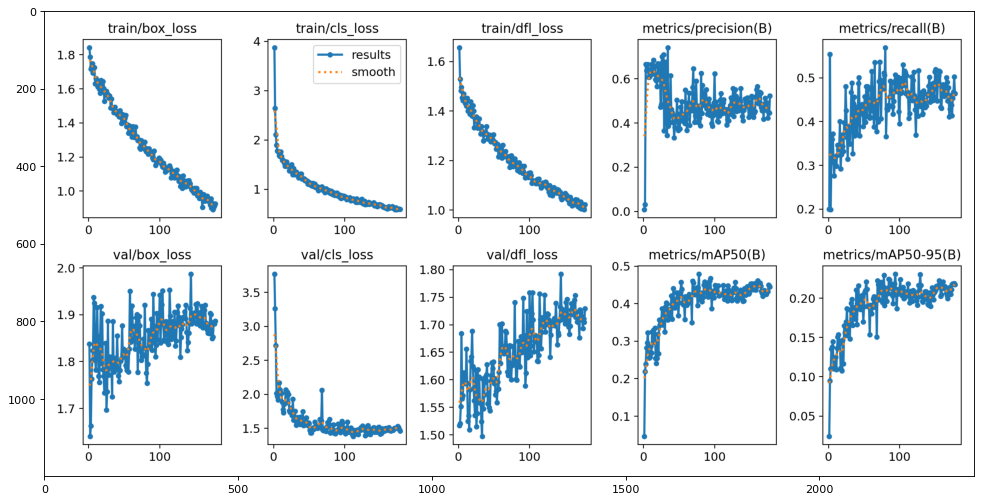

In [19]:
figure(figsize=(15, 10), dpi=80)
# reading the image 
results = img.imread('runs/detect/train3/results.png')   
# displaying the image 
plt.imshow(results) 

Let us now look at the confusion matrix, to better analyse the results:

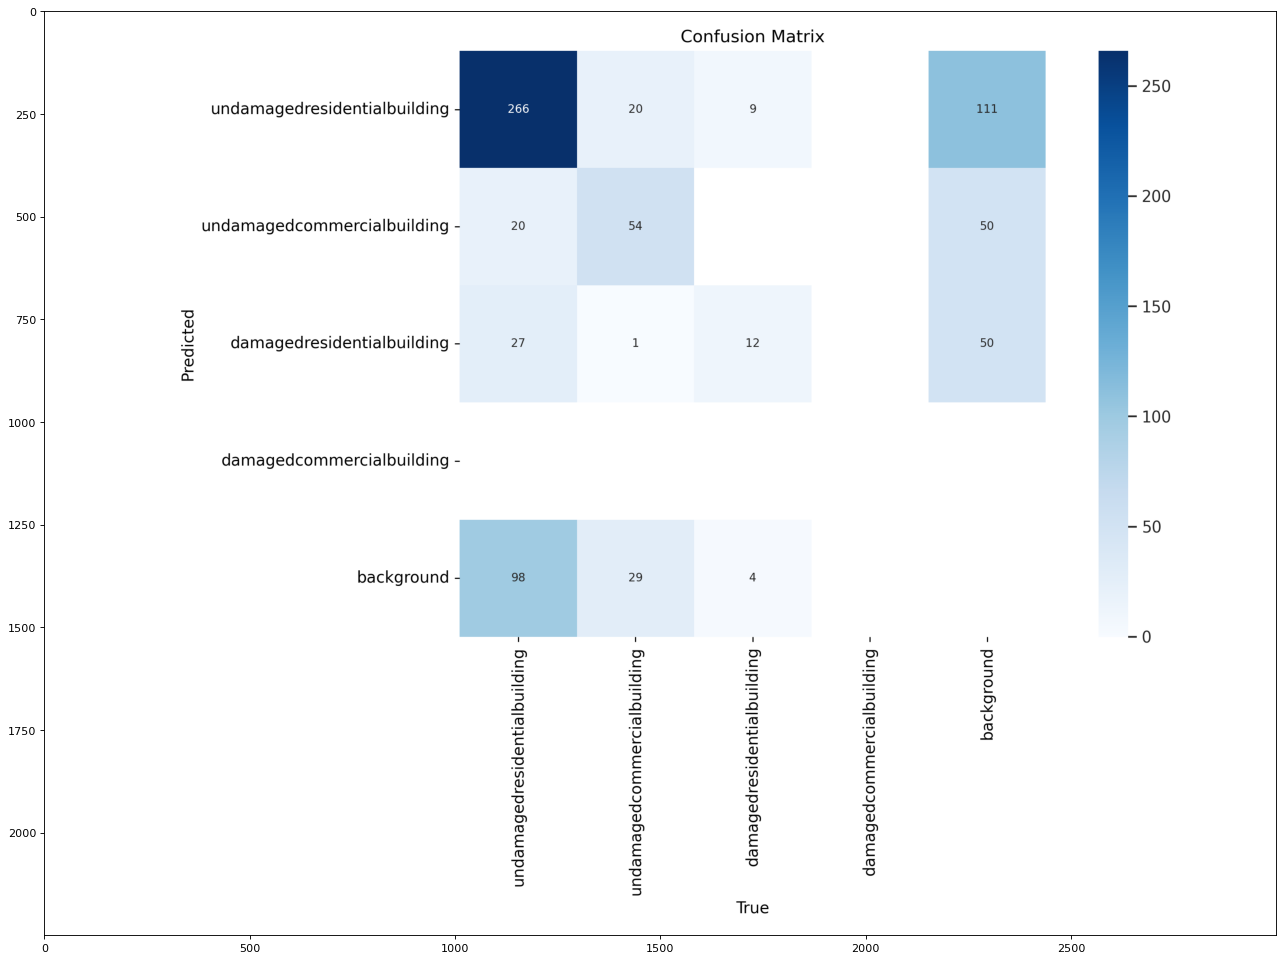

In [20]:
figure(figsize=(20,15), dpi=80)  
# reading the image 
cf = img.imread('runs/detect/train3/confusion_matrix.png') 
# displaying the image 
plt.imshow(cf) 

## Submission

Participants need to download the images from the submission section of the challenge portal.

In [12]:
def unzip_folder(zip_filepath, dest_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f'The zip file {zip_filepath} has been extracted to the directory {dest_dir}')



submission_zip = 'EY-data-science-project/challenge_1_submission_images/Validation_Data_JPEG'
submission_directory = 'EY-data-science-project/challenge_1_submission_images/Validation_Data_JPEG'
unzip_folder(submission_zip,submission_directory)

FileNotFoundError: [Errno 2] No such file or directory: 'EY-data-science-project/challenge_1_submission_images/Validation_Data_JPEG'

### Making Predictions on the Submission Data

In [21]:
# Load the Model
model = YOLO('./runs/detect/train3/weights/best.pt')

In [22]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'undamagedresidentialbuilding', 1: 'undamagedcommercialbuilding', 2: 'damagedresidentialbuilding', 3: 'damagedcommercialbuilding'}

directory = 'challenge_1_submission_images/Validation_Data_JPEG'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        
        for r in results:
            conf_list = r.boxes.conf.numpy().tolist()
            clss_list = r.boxes.cls.numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.boxes.xyxy.numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


challenge_1_submission_images/Validation_Data_JPEG/Validation_Post_Event_004.jpg
Making a prediction on  Validation_Post_Event_004.jpg

image 1/1 /home/jovyan/EY-data-science-project/challenge_1_submission_images/Validation_Data_JPEG/Validation_Post_Event_004.jpg: 512x512 8 undamagedresidentialbuildings, 4 damagedresidentialbuildings, 59.5ms
Speed: 1.1ms preprocess, 59.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict5
1 label saved to runs/detect/predict5/labels
Output files generated successfully.
challenge_1_submission_images/Validation_Data_JPEG/Validation_Post_Event_005.jpg
Making a prediction on  Validation_Post_Event_005.jpg

image 1/1 /home/jovyan/EY-data-science-project/challenge_1_submission_images/Validation_Data_JPEG/Validation_Post_Event_005.jpg: 512x512 30 undamagedresidentialbuildings, 2 damagedresidentialbuildings, 57.8ms
Speed: 1.0ms preprocess, 57.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 51

<b>Note: The submission file should contain only the .txt files and not the images.</b> 

In [23]:
# Define your source directory and the destination where the zip file will be created
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory Validation_Data_Results has been successfully zipped into submission.
